In [60]:
import glob
from PIL import Image
import matplotlib.pyplot as plt
from skimage import io

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import cmocean

import xesmf as xe

import matplotlib.colors

In [1]:
### averages over the last 50 years of the experiment and control runs were calculated with CDO ymonmean and timmean
### CDO setgrid was used to incorporate horizontal grid information from the ICON grid files (icon_grid_0030_R02B03_G.nc, icon_grid_0036_R02B04_O.nc)
### which were retrieved from the URLs given in the output data:
### http://icon-downloads.mpimet.mpg.de/grids/public/mpim/0030/icon_grid_0030_R02B03_G.nc  
### http://icon-downloads.mpimet.mpg.de/grids/public/mpim/0036/icon_grid_0036_R02B04_O.nc

In [125]:
def rad_to_deg(ds):
    """Convert radian units to deg."""
    ### https://gist.github.com/aaronspring/fd54970f71a39e26ab54a8b47170533d
    import numpy as np
    #ds.coords.compute()
    with xr.set_options(keep_attrs=True):
        for c in ds.coords:
            if 'units' in ds[c].attrs:
                if ds[c].attrs['units'] == 'radian':
                    # print(f'convert {c} from rad to deg')
                    ds[c] = ds[c]* 180./np.pi
                    ds[c].attrs['units'] = 'degrees'
            elif 'bnds' in c:
                # print(f'convert {c} from rad to deg')
                ds[c] = ds[c]* 180./np.pi
                ds[c].attrs['units'] = 'degrees'
    return ds

# grid_1deg = xe.util.grid_global(1,1)
grid_1deg = xr.Dataset(
    {"lat": (["lat"], np.arange(-89.5, 89.5+1, 1.)),
     "lon": (["lon"], np.arange(-179.5, 179.5+1, 1.)),
     "lat_b": (["lat_b"], np.arange(-90, 90+1, 1.)),
     "lon_b": (["lon_b"], np.arange(-180, 180+1, 1.))})


def regrid_rec(ds_in):
    ds_in=rad_to_deg(ds_in)
    ds_in=ds_in.rename({'clon':'lon','clat':'lat'})
    ds_out=grid_1deg
    ### https://github.com/pangeo-data/xESMF/issues/115
    ### https://gist.github.com/aaronspring/fd54970f71a39e26ab54a8b47170533d
    re = xe.Regridder(ds_sel, ds_out, method='nearest_s2d', locstream_in=True)
    ds_re = re(ds_in)
    
    ds_re.attrs=ds_in.attrs
    for vv in ds_re.data_vars:
        dsre.data_vars[vv].attrs=ds_in.data_vars[vv].attrs
    
    return ds_re

In [126]:
ds_atm_2d=xr.open_dataset('./data/sus22F0_atm_2d_ml_last50yrs_setgrid.nc')
ds_atm_2d_ctrl=xr.open_dataset('./data/sus2200_atm_2d_ml_last50yrs_setgrid.nc')

ds_lnd_ctrl=xr.open_dataset('./data/sus2200_lnd_basic_ml_last50yrs_setgrid.nc')

grid_atm=xr.open_dataset('./data/icon_grid_0030_R02B03_G.nc')

/home/jan/miniconda3/lib/python3.9/site-packages/xarray/coding/times.py:527: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/jan/miniconda3/lib/python3.9/site-packages/xarray/coding/times.py:527: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/jan/miniconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/home/jan/miniconda3/lib/python3.9/site-packages/xarray/coding/times.py:527: Seri

In [119]:
ds_atm_2d_regrid=regrid_rec(ds_atm_2d)
ds_atm_2d_ctrl_regrid=regrid_rec(ds_atm_2d_ctrl)

ds_lnd_ctrl_regrid=regrid_rec(ds_lnd_ctrl)

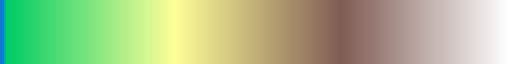

In [110]:
# Combine the lower and upper range of the terrain colormap with a gap in the middle
# to let the coastline appear more prominently.
# inspired by https://stackoverflow.com/questions/31051488/combining-two-matplotlib-colormaps
colors_undersea = plt.cm.terrain(np.linspace(0.1, 0.11, 2)) #plt.cm.terrain(np.linspace(0, 0.17, 56))
colors_land = plt.cm.terrain(np.linspace(0.25, 1, 200)) #plt.cm.terrain(np.linspace(0.25, 1, 200))
# combine them and build a new colormap
colors = np.vstack((colors_undersea, colors_land))
cut_terrain_map = matplotlib.colors.LinearSegmentedColormap.from_list('cut_terrain', colors)
cut_terrain_map

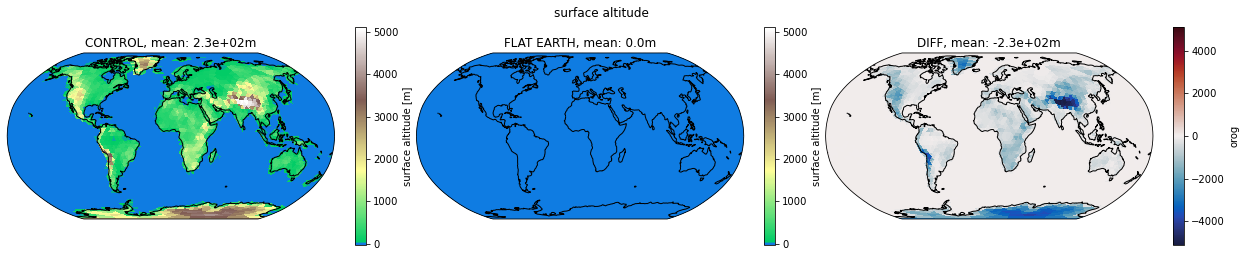

In [127]:
var=ds_atm_2d_regrid.orog
var_ctrl=ds_atm_2d_ctrl_regrid.orog
var_diff=(var-var_ctrl)

vmin=var.min()
vmax=var.max()
if vmin>var_ctrl.min():
    vmin=var_ctrl.min()
if vmax<var_ctrl.max():
    vmax=var_ctrl.max()

fig,axs=plt.subplots(1,3,subplot_kw={'projection': ccrs.Robinson()},figsize=[22,4])
var_ctrl.plot(ax=axs[0],transform=ccrs.PlateCarree(),vmin=vmin,vmax=vmax,cmap=cut_terrain_map) #,vmin=vmin,vmax=vmax ,cmap=cmocean.cm.matter
var.plot(ax=axs[1],transform=ccrs.PlateCarree(),vmin=vmin,vmax=vmax,cmap=cut_terrain_map)
var_diff.plot(ax=axs[2],transform=ccrs.PlateCarree(),cmap=cmocean.cm.balance) #,vmin=-4,vmax=4

for aa in axs:
    aa.coastlines()
    #ax.set_extent([-160, 180, 5, 90])

weights = np.cos(np.deg2rad(var.lat))
var_mean = float(var.weighted(weights).mean(("lon", "lat")).values)
var_ctrl_mean = float(var_ctrl.weighted(weights).mean(("lon", "lat")).values)
var_diff_mean=float(var_diff.weighted(weights).mean(("lon", "lat")).values)

axs[0].set_title('CONTROL, mean: {:.2}m'.format(var_ctrl_mean))
axs[1].set_title('FLAT EARTH, mean: {:.2}m'.format(var_mean))
axs[2].set_title('DIFF, mean: {:+.2}m'.format(var_diff_mean))

fig.suptitle('{}'.format(var.attrs['long_name']),y=0.95)

plt.subplots_adjust(wspace=0)

# fig.savefig('../../plots_diff/{}/precipitation.jpg'.format(mm,varname),dpi=200, bbox_inches='tight', pad_inches=0)



In [2]:
modules=['atm_2d_ml','atm_3d_ml','atm_mon','lnd_basic_ml','lnd_mon','oce_mon','oce_P1M_3d','oce_P1M_moc','oce_P1M_sqr']

vars_sel=['pr']

for mm in [modules[0]]:
    
    ds=     xr.open_dataset('/work/mh1049/k206174/icon-easyms/ensemble_mean_regrided/sus22F0_1deg_{}_50yrsmean.nc'.format(mm))
    ds_ctrl=xr.open_dataset('/work/mh1049/k206174/icon-easyms/ensemble_mean_regrided/sus2200_1deg_{}_50yrsmean.nc'.format(mm))    
    print(mm)

    for varname, da in ds.data_vars.items():         
        if varname in vars_sel:


            var=ds.data_vars[varname]*60*60*24
            var_ctrl=ds_ctrl.data_vars[varname]*60*60*24 #.mean(dim='time')
            if 'height' in var.coords:
                var=var.isel(height=0)
                var_ctrl=var_ctrl.isel(height=0)
            if 'depth' in var.coords:
                var=var.isel(depth=0)
                var_ctrl=var_ctrl.isel(depth=0)
            if 'time' in var.coords:
                var=var.isel(time=0)
                var_ctrl=var_ctrl.isel(time=0)
            var_diff=var-var_ctrl
            var_diff.attrs=ds.data_vars[varname].attrs
            var.attrs=ds.data_vars[varname].attrs
            var_ctrl.attrs=ds.data_vars[varname].attrs

            vmin=var.min()
            vmax=var.max()
            if vmin>var_ctrl.min():
                vmin=var_ctrl.min()
            if vmax<var_ctrl.max():
                vmax=var_ctrl.max()

            if 'lat' in var.coords and 'lon' in var.coords:
                fig,axs=plt.subplots(1,3,subplot_kw={'projection': ccrs.Robinson()},figsize=[22,4])
                var.plot(ax=axs[1],transform=ccrs.PlateCarree(),vmin=0,vmax=vmax ,cmap=cmocean.cm.rain) #,vmin=vmin,vmax=vmax ,cmap=cmocean.cm.matter
                var_ctrl.plot(ax=axs[0],transform=ccrs.PlateCarree(),vmin=0,vmax=vmax ,cmap=cmocean.cm.rain) #,vmin=vmin,vmax=vmax ,cmap=cmocean.cm.matter
                var_diff.plot(ax=axs[2],transform=ccrs.PlateCarree(),vmin=-4,vmax=4,cmap=cmocean.cm.balance) #,vmin=-1e3,vmax=1e3,cmap='RdBu'
                for aa in axs:
                    aa.coastlines()
                    #ax.set_extent([-160, 180, 5, 90])

                weights = np.cos(np.deg2rad(var.lat))
                var_mean = float(var.weighted(weights).mean(("lon", "lat")).values)
                var_ctrl_mean = float(var_ctrl.weighted(weights).mean(("lon", "lat")).values)
                var_diff_mean=float(var_diff.weighted(weights).mean(("lon", "lat")).values)

                axs[0].set_title('CONTROL, mean: {:.2} mm/d'.format(var_ctrl_mean))
                axs[1].set_title('FLAT EARTH, mean: {:.2} mm/d'.format(var_mean))
                axs[2].set_title('DIFF, mean: {:+.2} mm/d'.format(var_diff_mean))

            else:
                fig,axs=plt.subplots(1,3,figsize=[22,5])
                var.plot(ax=axs[1]) #,vmin=vmin,vmax=vmax ,cmap=cmocean.cm.matter
                var_ctrl.plot(ax=axs[0]) #,vmin=vmin,vmax=vmax ,cmap=cmocean.cm.matter
                var_diff.plot(ax=axs[2]) #,vmin=-1e3,vmax=1e3,cmap='RdBu'

            if 'long_name' in var.attrs:        
                fig.suptitle('{}'.format(var.attrs['long_name']),y=0.95)
                print('    {}, {}'.format(varname,var.attrs['long_name']))
            else:
                fig.suptitle('{}'.format(varname),y=0.95)
                print('    {}'.format(varname))
            plt.subplots_adjust(wspace=0)
            fig.savefig('../../plots_diff/{}/precipitation.jpg'.format(mm,varname),dpi=200, bbox_inches='tight', pad_inches=0)
            #print('    {}, {}'.format(varname,var.attrs['long_name']))


In [ ]:
### Calculate atmospheric data on pressure levels (adopted from atm_circul.py from Hairu Ding)

import sys
sys.path.insert(0,'/home/k/k206174/pyicon_easyms22') 
import pyicon as pyic

gridpath = "/work/mh0033/m300602/icon/grids/r2b3_atm_r0030/ckdtree/rectgrids/r2b3_atm_r0030_res1.00_180W-180E_90S-90N.npz"    
#ds = xr.open_dataset(f'/work/mh1049/k206174/icon-easyms/last50yrs_mean/sus22F_ensmean_atm_3d_ml_50yrsmean.nc')
ds = xr.open_dataset(f'/work/mh1049/k206174/icon-easyms/last50yrs_mean/sus2200_control_atm_3d_ml_50yrsmean.nc')
pfull = ds.pfull.data
zg = ds.zg.data
ua = ds.ua.data[0,:,:]
va = ds.va.data[0,:,:]
ta = ds.ta.data[0,:,:]
hus = ds.hus.data[0,:,:]

plevc = np.array([100000,92500,85000,77500,70000,60000,50000,40000,30000,25000,20000,15000,10000,7000,5000,3000,1000])    
icall, ind_lev, fac = pyic.calc_vertical_interp_weights(pfull[0,:,:], plevc)

### From pyIcon pyicon_tb.py
def calc_vertical_interp_weights(zdata, levs, increases_along_axes=True):
  """ Calculate vertical interpolation weights and indices.

Call example:
icall, ind_lev, fac = calc_vertical_interp_weights(zdata, levs)

Afterwards do interpolation like this:
datai = data[ind_lev,icall]*fac+data[ind_lev+1,icall]*(1.-fac)
  """
  nza = zdata.shape[0]
  # --- initializations
  ind_lev = np.zeros((levs.size,zdata.shape[1]),dtype=int)
  icall = np.arange(zdata.shape[1],dtype=int)
  icall = icall[np.newaxis,:]
  fac = np.ma.zeros((levs.size,zdata.shape[1]))
  for k, lev in enumerate(levs):
    #print(f'k = {k}')
    # --- find level below critical level
    if increases_along_axes:
      ind_lev[k,:] = (zdata<levs[k]).sum(axis=0)-1
    else:
      ind_lev[k,:] = (zdata>levs[k]).sum(axis=0)-1
    ind_lev[k,ind_lev[k,:]==(nza-1)]=-1
    # --- zdata below and above lev 
    zd1 = zdata[ind_lev[k,:],icall]
    zd2 = zdata[ind_lev[k,:]+1,icall]
    # --- linear interpolation to get weight (fac=1 if lev=zd1)
    fac[k,:] = (0.-1.)/(zd2-zd1)*(levs[k]-zd1)+1.
